In [1]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()


Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import re

from tqdm import tqdm

import pydicom as dicom
import nibabel as nib

import pydicom
from pydicom.data import get_testdata_files
import plotly.express as px
from pprint import pprint
import nibabel as nib
from ipywidgets import interact
DS_RATE = 2

In [3]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00


In [5]:
def create_3D_scans(folder, downsample_rate=1):
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]

    volume = []
    for filename in tqdm(filenames[::downsample_rate]):
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array

        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)

        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2


        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )

    volume = np.stack(volume, axis=0)
    return volume


def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img



filepath = 'segmentations/21057.nii'
volume_seg = create_3D_segmentations(filepath, downsample_rate=DS_RATE)
print(f'3D segmentation file shape: {volume_seg.shape}')

filepath = 'train_images/10004/21057'
volume = create_3D_scans(filepath, downsample_rate=DS_RATE)
print(f'3D Image file shape: {volume.shape}')

3D segmentation file shape: (511, 256, 256)


100%|██████████| 511/511 [00:37<00:00, 13.60it/s]


3D Image file shape: (511, 256, 256)


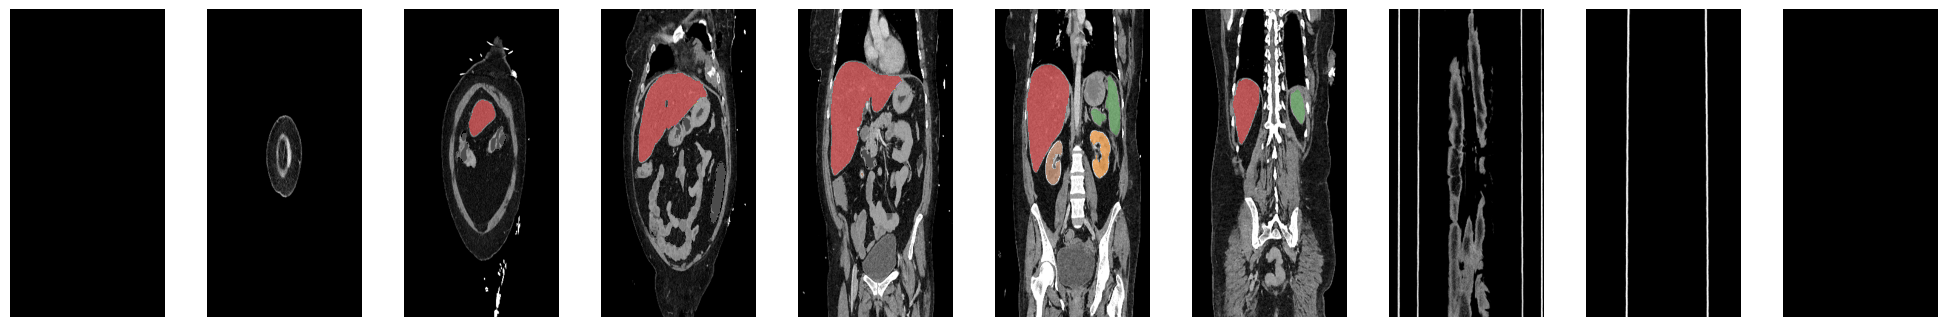

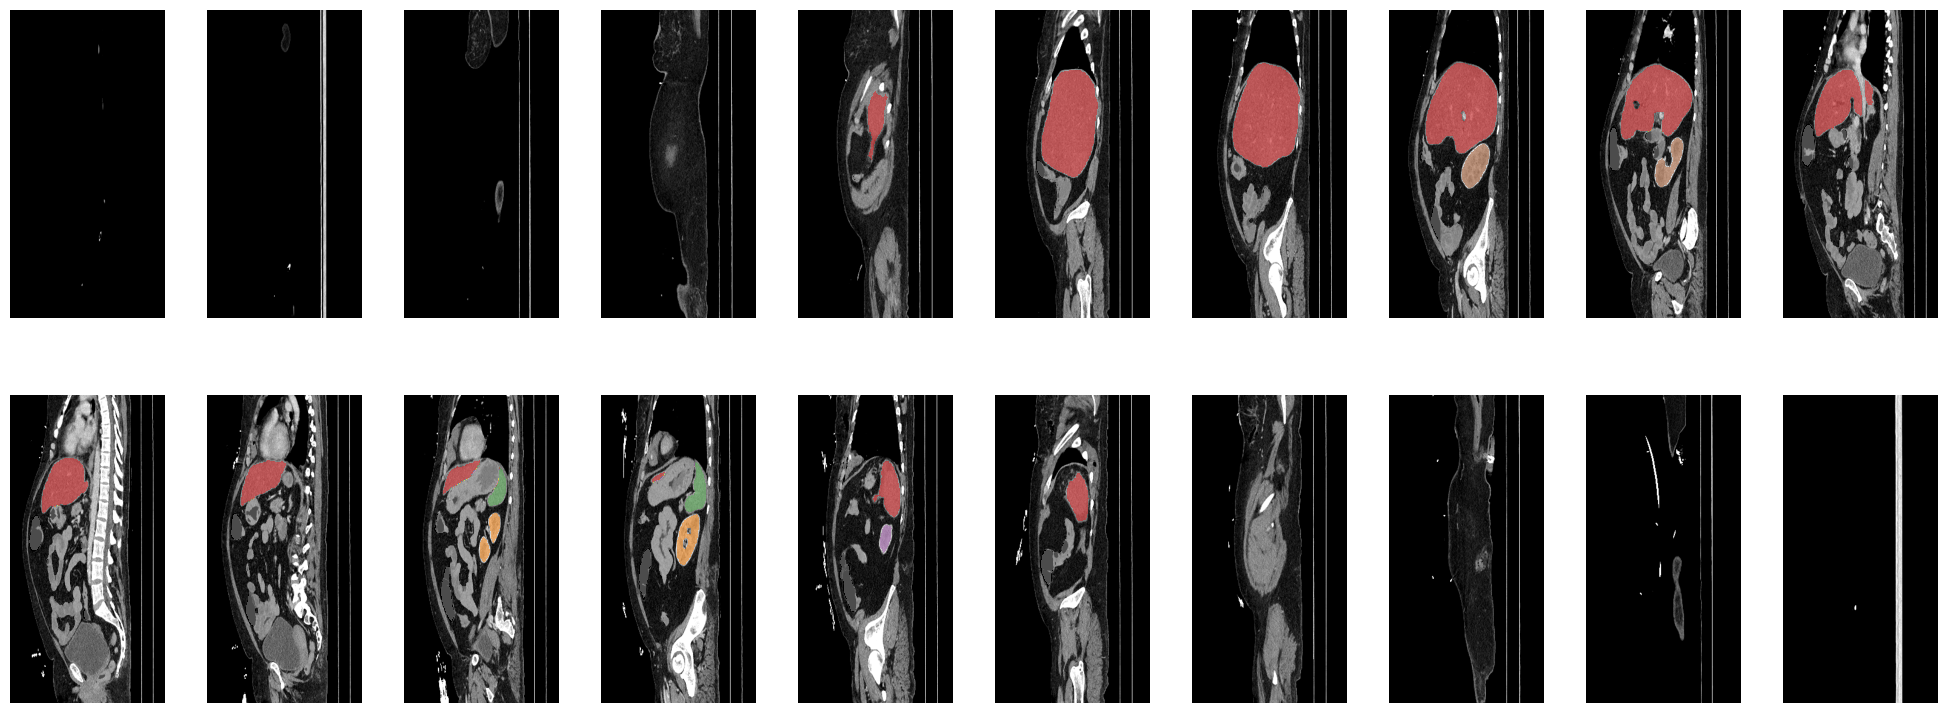

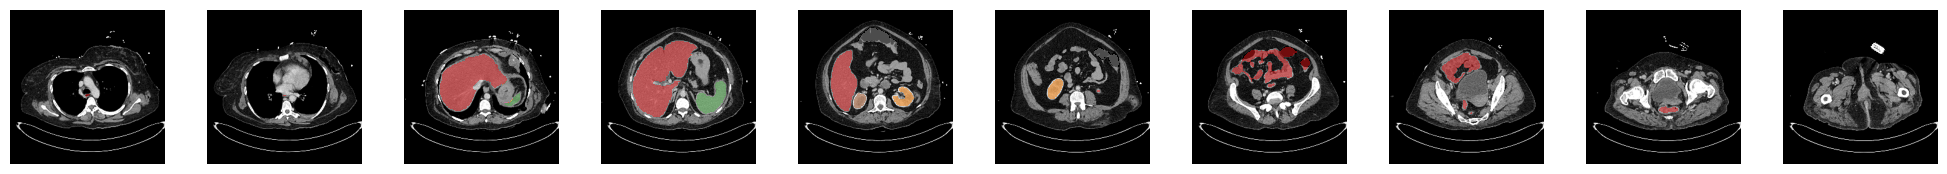

In [6]:
def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1

    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])

    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)

    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)

    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)

    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])

        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')

        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)




plot_image_with_seg(volume, volume_seg, orientation='Coronal', num_subplots=10)
plot_image_with_seg(volume, volume_seg, orientation='Sagittal', num_subplots=20)
plot_image_with_seg(volume, volume_seg, orientation='Axial', num_subplots=10)